## BUILD A MODEL ON MNIST DATA

In [36]:
# IMPORT LIBRARIES
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

In [37]:
# LOAD MNIST DATA
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [38]:
# NORMALIZA THE IMAGE DATA
train_images = train_images / 255.0
test_images = test_images / 255.0

In [39]:
# DEFINE THE MODEL ARCHITECTURE
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

In [40]:
# TRAIN THE DIGIT CLASSIFICATION MODEL
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.3088 - accuracy: 0.9125 - val_loss: 0.1554 - val_accuracy: 0.9561


THE MODEL ACCURACY ON SINGLE EPOCH HITS 96%

In [41]:
# USING THE TENSORFLOW LITE CONVERTER, WE CAN CONVERT THE TRAINED MODEL INTO THE TENSORFLOW LITE
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [43]:
# SAVE THE MODEL INTO DIRECTORIES
tflite_models_dir = pathlib.Path("mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84896

In [46]:
# TO QUANNTIZE A MODEL ON EXPORT, SET THE OPTIMIZATIONS FLAG TO OPTIMIZE FOR SIZE
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

24136

In [47]:
ls -lh {tflite_models_dir}

total 108K
-rw-r--r-- 1 root root 83K Dec 30 09:56 mnist_model.tflite
-rw-r--r-- 1 root root 24K Dec 30 10:00 mnist_model_quant.tflite


WE HAVE MINIMIZED THE SIZE OF THE MODEL, WHAT ABOUT IT PERFORMANCE?

In [49]:
# INTERPRETER

# ORIGINAL MODEL
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

# QUANTIZED MODEL
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [54]:
# TEST THE MODEL ON SINGLE IMAGE
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

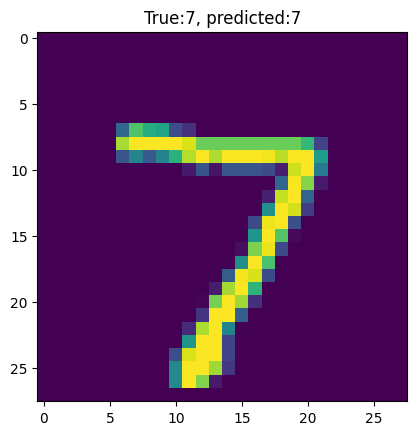

In [55]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted :{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [58]:
#  A FUNCTION TO EVALUATE THE TF LITE MODEL USING TEST DATA
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in test_images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == test_labels[index]:
            accurate_count += 1
        accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy

In [59]:
print(evaluate_model(interpreter))

0.9561


In [60]:
print(evaluate_model(interpreter_quant))

0.9562
